In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from random import sample
import random
import gzip
import gzip
import shutil
import matplotlib.pyplot as plt


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [3]:
torch.manual_seed(78263992)

# specify device depending on availability of GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Helper functions

In [4]:
# wraps a separated dataset to avoid issues while shuffling
class WrapperDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.y)

# get the same batch split for inputs and labels
def get_batched_x_y(x, y, batch_size, shuffle):
    dataset = WrapperDataset(x, y)
    batched = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return batched

def getMalicious(X, y):
    X_mal = []
    for i in range(len(y)):
        if y[i] == 1:
            X_mal.append(X[i])
    X_mal = torch.stack(X_mal)
    y_mal = y[y.nonzero()].squeeze(1)
    
    return X_mal, y_mal

def zeroPadInput(inputs, amount=50):
    # adds zero padding vectors to the end of each sequence
    for i in range(len(inputs)):
        zero_padding = torch.zeros(inputs[i].shape[0], amount, inputs[i].shape[2])
        inputs[i] = torch.cat([inputs[i], zero_padding], dim=1)
    return inputs



## Data Loading

In [5]:
X_train = torch.load("X_train.pt").to_dense()
X_val = torch.load("X_val.pt").to_dense()
X_test = torch.load("X_test.pt").to_dense()
y_train = torch.load("y_train.pt")
y_val = torch.load("y_val.pt")
y_test = torch.load("y_test.pt")

In [6]:
X_train, X_val, X_test = zeroPadInput([X_train, X_val, X_test])

## Model Loading

In [7]:
hidden_size = 128
lstm_layers = 1
epochs = 100
train_batch_size = 256
early_stopping_patience = 7

In [8]:
input_size = X_train.shape[2]
sequence_size = X_train.shape[1]
loss_function = nn.BCEWithLogitsLoss()

In [9]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_layers, pooling):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True)
        self.pool = pooling(sequence_size)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out = self.lstm(x)[0]
        pool_out = self.pool(lstm_out.permute(0, 2, 1))
        linear_out = self.linear(pool_out.squeeze())
        return torch.squeeze(linear_out)

In [10]:
def predict(x, model):
    myX = x.to(device)
    output = model(myX)
    return output > 0

In [11]:
def initModel(input_size, hidden_size, lstm_layers, pooling):
    model = Net(input_size, hidden_size, lstm_layers, pooling)
    model.to(device)
    return model
model = initModel(input_size, hidden_size, lstm_layers, nn.MaxPool1d)
model

Net(
  (lstm): LSTM(264, 128, batch_first=True)
  (pool): MaxPool1d(kernel_size=150, stride=150, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [12]:
def test(x, y, model, batch_size, loss_function):
    averageLoss = 0.0
    averageSensitivity = 0.0
    averageSpecificity = 0.0
    numBatches = 0
    # batch the data set
    batched = get_batched_x_y(x, y, batch_size, False)
    for xi, yi in batched:
        # move data to device
        xi = xi.to(device)
        yi = yi.to(device)
        # forward pass through model
        output = model(xi)
        # calculate current loss of model
        loss = loss_function(output, yi)
        # calculate measures
        predicted = output > 0
        matches = yi == predicted
        sensitivity = matches[yi == 1].sum() / (yi == 1).sum()
        specificity = matches[yi == 0].sum() / (yi == 0).sum()
        # record all values
        averageSensitivity += sensitivity.item()
        averageSpecificity += specificity.item()
        averageLoss += loss.item()
        numBatches += 1
    averageSensitivity /= numBatches
    averageSpecificity /= numBatches
    averageLoss /= numBatches
    measures = (averageSensitivity, averageSpecificity)
    return measures, averageLoss

In [13]:
model.load_state_dict(torch.load('final-lstm-model.pt'))
model.eval()

Net(
  (lstm): LSTM(264, 128, batch_first=True)
  (pool): MaxPool1d(kernel_size=150, stride=150, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [14]:
test_measures, test_loss = test(X_test, y_test, model, len(y_test), loss_function)
print("Test Loss {:.6f} Sensitivity {:.3f} Specificity {:.3f}"
         .format(test_loss, test_measures[0], test_measures[1]))

Test Loss 0.073531 Sensitivity 0.976 Specificity 0.935


In [15]:
model.train()

Net(
  (lstm): LSTM(264, 128, batch_first=True)
  (pool): MaxPool1d(kernel_size=150, stride=150, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

# Attacks

In [16]:
#create API dictionary
idx = torch.tensor(range(0, 264))
api_dict = torch.zeros(len(idx), idx.max()+1).scatter_(1, idx.unsqueeze(1), 1.)

In [17]:
#insertion of api into sequence
def insert_api(seq, api, i):
    api = api.to(device)
    new_seq = torch.cat((torch.cat((seq[:i],api.unsqueeze(0))),seq[i:-1]))
    return new_seq 

In [18]:
X_val_mal, y_val_mal = getMalicious(X_val, y_val)
batched_data = get_batched_x_y(X_val_mal, y_val_mal, 64, False)
X_val_mal = []
for xi, yi in batched_data:
    X_val_mal.append(xi)

<ipython-input-4-1b10f05afa54>:25: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:962.)
  y_mal = y[y.nonzero()].squeeze(1)


In [19]:
#batched version (jacobian is calculated at every batch instead of every sample)
def advGeneration(X_init, model, surrogate_model):
    for m in range(len(X_init)):
        xi = X_init[m].clone()
        xi.requires_grad = True
        xi = xi.to(device)
        jacobian = torch.diagonal(torch.autograd.functional.jacobian(surrogate_model.forward, xi)).permute(2, 0, 1)
        for i in range(xi.shape[0]):
            x_sample = xi[i]
            counter = 0   
            while predict(x_sample.unsqueeze(0), model)and counter<50:
                random_position = random.randint(0,torch.count_nonzero(x_sample.detach())-1)
                    #check if sample is predicted as benign
                api_difs = []
                for api in api_dict:
                    #insert API into sequence
                    new_seq = insert_api(x_sample.squeeze(), api, random_position)
                    #norm of difference between new sequence and jacobian
                    dif = torch.norm(torch.sign(x_sample) - torch.sign(jacobian[i]))
                    api_difs.append((dif,new_seq))
                min_seq = min(api_difs, key = lambda t: t[0])
                #replace sequence
                xi[i] = min_seq[1]
                counter += 1
            #replace batch
            X_init[m] = xi
    return X_init

## Whitebox Attack

In [29]:
whitebox_adv = advGeneration(X_val_mal, model, model)

5
2
9
32
2
0
10
17


KeyboardInterrupt: 

In [353]:
torch.save(whitebox_adv, 'whitebox_adv_val.pt')

In [354]:
with open('whitebox_adv_val.pt', 'rb') as f_in:
    with gzip.open('whitebox_adv_val.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

## Surrogate Model Loading

In [20]:
hidden_size = 256
lstm_layers = 2
training_epochs = 10
augmentation_epochs = 3
train_batch_size = 256
epsilon = 1e-2

In [21]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_layers, pooling):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True)
        self.pool = pooling(sequence_size)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out = self.lstm(x)[0]
        pool_out = self.pool(lstm_out.permute(0, 2, 1))
        linear_out = self.linear(pool_out.squeeze())
        return torch.squeeze(linear_out)

In [22]:
def initModel(input_size, hidden_size, lstm_layers, pooling):
    model = Net(input_size, hidden_size, lstm_layers, pooling)
    model.to(device)
    return model
surrogateModel = initModel(input_size, hidden_size, lstm_layers, nn.MaxPool1d)
surrogateModel

Net(
  (lstm): LSTM(264, 256, num_layers=2, batch_first=True)
  (pool): MaxPool1d(kernel_size=150, stride=150, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [23]:
surrogateModel.load_state_dict(torch.load("surrogate-model.pt"))

<All keys matched successfully>

## Blackbox Attack

In [38]:
blackbox_adv = advGeneration(X_val_mal, model, surrogateModel)

16
6
19
12
7
0


KeyboardInterrupt: 

In [478]:
torch.save(blackbox_adv, 'blackbox_adv_val.pt') 

In [479]:
with open('blackbox_adv_val.pt', 'rb') as f_in:
    with gzip.open('blackbox_adv_val.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

## Blackbox and whitebox performance 

In [24]:
def get_failed_attacks(adv_samples, model):
    samples = adv_samples.to(device)
    prediction = model(samples)
    return (prediction >= 0).cpu()
    
def count_added_api(adv_samples):
    added_api = []
    for seq in adv_samples:
        added_api_counter = 0
        for api in seq:
            if (len(torch.nonzero(api) == 0)):
                added_api_counter += 1
        added_api.append(added_api_counter-100)
    return np.array(added_api)

def remove_zeros_and_failed(api_counts, failed_attacks):
    return api_counts[torch.logical_and(torch.tensor(api_counts != 0), torch.logical_not(failed_attacks))]

In [25]:
whitebox_adv =  torch.load('whitebox_adv_val.pt') 
blackbox_adv =  torch.load('blackbox_adv_val.pt') 

In [26]:
whitebox_adv = torch.cat(whitebox_adv).cpu()
blackbox_adv = torch.cat(blackbox_adv).cpu()

### Overhead

In [27]:
def printOverhead(name, adv_samples, model):
    failed = get_failed_attacks(adv_samples, model)
    count_api = count_added_api(adv_samples)
    count_filtered = remove_zeros_and_failed(count_api, failed)
    overhead = np.mean(count_filtered/100)
    print(name, "overhead:", str(overhead))

In [28]:
printOverhead("Whitebox attack", whitebox_adv, model)
printOverhead("Blackbox attack", blackbox_adv, model)

Whitebox attack overhead: 0.17072665203608878
Blackbox attack overhead: 0.16809117503656754


### Accuracy

In [29]:
def printEffectiveness(name, adv_samples, model):
    failed = get_failed_attacks(adv_samples, model)
    count_api = count_added_api(adv_samples)
    count_filtered = remove_zeros_and_failed(count_api, failed)
    effectiveness = torch.logical_not(failed[count_api != 0]).sum()/(count_api != 0).sum()
    effectiveness = effectiveness.item()
    print(name, "effectiveness:", str(effectiveness))

In [30]:
printEffectiveness("Whitebox attack", whitebox_adv, model)
printEffectiveness("Blackbox attack", blackbox_adv, model)

Whitebox attack effectiveness: 0.9834532141685486
Blackbox attack effectiveness: 0.9836930632591248


## Plot

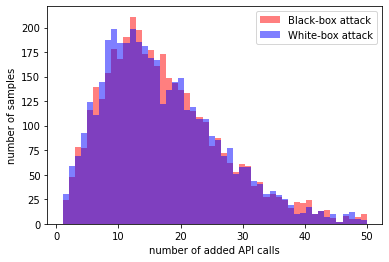

In [31]:
blackbox_count_filtered = remove_zeros_and_failed(count_added_api(whitebox_adv), get_failed_attacks(whitebox_adv, model))
whitebox_count_filtered = remove_zeros_and_failed(count_added_api(blackbox_adv), get_failed_attacks(blackbox_adv, model))
plt.hist(blackbox_count_filtered, bins=50, color = 'r', label = "Black-box attack",alpha=0.5)
plt.hist(whitebox_count_filtered, bins=50, color = 'b',label = "White-box attack", alpha=0.5)
plt.ylabel("number of samples")
plt.xlabel("number of added API calls")
plt.legend(loc = 'best')
plt.show()

## Random Adversarial Generation

In [54]:
X_val_mal, y_val_mal = getMalicious(X_val, y_val)
batched_data = get_batched_x_y(X_val_mal, y_val_mal, 64, False)
X_val_mal = []
for xi, yi in batched_data:
    X_val_mal.append(xi)

In [55]:
#batched version (jacobian is calculated at every batch instead of every sample)
def advGenerationRandom(X_init, model):  
    for m in range(len(X_init)):
        xi = X_init[m]
        xi = xi.to(device)
        for i in range(xi.shape[0]):
            x_sample = xi[i]
            counter = 0
            while predict(x_sample.unsqueeze(0), model) and counter<50:
                random_position = random.randint(0,torch.count_nonzero(x_sample.detach())-1)
                #insert API into sequence
                new_seq = insert_api(x_sample.squeeze(), random.choice(api_dict), random_position)
                #replace sequence
                counter += 1
                xi[i] = new_seq
            #replace batch
            X_init[m] = xi
    return X_init

In [56]:
random_adv = advGenerationRandom(X_val_mal, model)

## Random attack performance 

In [57]:
random_adv = torch.cat(random_adv).cpu()

### Accuracy

In [58]:
printEffectiveness("Random attack", random_adv, model)

Random attack effectiveness: 0.07074340432882309


# Attacks against hardened models

## Hardened LSTM model loading

In [32]:
hidden_size = 128
lstm_layers = 1
epochs = 100
train_batch_size = 256
early_stopping_patience = 7

In [33]:
input_size = X_train.shape[2]
sequence_size = X_train.shape[1]
loss_function = nn.BCEWithLogitsLoss()

In [34]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_layers, pooling):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True)
        self.pool = pooling(sequence_size)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out = self.lstm(x)[0]
        pool_out = self.pool(lstm_out.permute(0, 2, 1))
        linear_out = self.linear(pool_out.squeeze())
        return torch.squeeze(linear_out)

In [35]:
def initModel(input_size, hidden_size, lstm_layers, pooling):
    model = Net(input_size, hidden_size, lstm_layers, pooling)
    model.to(device)
    return model
hardenedLSTMModel = initModel(input_size, hidden_size, lstm_layers, nn.MaxPool1d)
model

Net(
  (lstm): LSTM(264, 128, batch_first=True)
  (pool): MaxPool1d(kernel_size=150, stride=150, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [36]:
hardenedLSTMModel.load_state_dict(torch.load("hardened-lstm-model.pt"))

<All keys matched successfully>

## Hardened whitebox attack

In [169]:
X_test_mal, y_test_mal = getMalicious(X_test, y_test)
batched_data = get_batched_x_y(X_test_mal, y_test_mal, 64, False)
X_test_mal = []
for xi, yi in batched_data:
    X_test_mal.append(xi)

In [140]:
hardened_whitebox_adv = advGeneration(X_test_mal, hardenedLSTMModel, hardenedLSTMModel)

In [142]:
torch.save(hardened_whitebox_adv, 'hardened_whitebox_adv_test.pt') 

## Hardened whitebox performance

In [38]:
hardened_whitebox_adv = torch.load('hardened_whitebox_adv_test.pt')

In [39]:
hardened_whitebox_adv = torch.cat(hardened_whitebox_adv).cpu()

### Accuracy

In [44]:
printEffectiveness("hardened Whitebox attack", hardened_whitebox_adv, hardenedLSTMModel)

hardened Whitebox attack effectiveness: 0.007045797538012266


## Hardened surrogate model loading

In [45]:
hidden_size = 256
lstm_layers = 2
training_epochs = 10
augmentation_epochs = 3
train_batch_size = 256
epsilon = 1e-2

In [46]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_layers, pooling):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True)
        self.pool = pooling(sequence_size)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out = self.lstm(x)[0]
        pool_out = self.pool(lstm_out.permute(0, 2, 1))
        linear_out = self.linear(pool_out.squeeze())
        return torch.squeeze(linear_out)

In [47]:
def initModel(input_size, hidden_size, lstm_layers, pooling):
    model = Net(input_size, hidden_size, lstm_layers, pooling)
    model.to(device)
    return model
hardenedSurrogateModel = initModel(input_size, hidden_size, lstm_layers, nn.MaxPool1d)
hardenedSurrogateModel

Net(
  (lstm): LSTM(264, 256, num_layers=2, batch_first=True)
  (pool): MaxPool1d(kernel_size=150, stride=150, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [48]:
hardenedSurrogateModel.load_state_dict(torch.load("hardened-surrogate-model.pt"))

<All keys matched successfully>

## Hardened blackbox attack

In [176]:
hardened_blackbox_adv = advGeneration(X_test_mal, hardenedLSTMModel, hardenedSurrogateModel)

In [178]:
torch.save(hardened_blackbox_adv, 'hardened_blackbox_adv_test.pt')

## Hardened blackbox performance


In [51]:
hardened_blackbox_adv = torch.load('hardened_blackbox_adv_test.pt')

In [52]:
hardened_blackbox_adv = torch.cat(hardened_blackbox_adv).cpu()

### Accuracy

In [53]:
printEffectiveness("hardened Blackbox attack", hardened_blackbox_adv, hardenedLSTMModel)

hardened Blackbox attack effectiveness: 0.008807247504591942


## Hardened random attack

In [59]:
X_test_mal, y_test_mal = getMalicious(X_test, y_test)
batched_data = get_batched_x_y(X_test_mal, y_test_mal, 64, False)
X_test_mal = []
for xi, yi in batched_data:
    X_test_mal.append(xi)

In [60]:
hardened_random_adv = advGenerationRandom(X_test_mal, hardenedLSTMModel)

## Hardened random performance 

In [61]:
hardened_random_adv = torch.cat(hardened_random_adv).cpu()

### Accuracy

In [62]:
printEffectiveness("hardened Random attack", hardened_random_adv, model)

hardened Random attack effectiveness: 0.012833417393267155
